In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
from src.yolo.v1.dataset import YOLOv1Dataset
from src.utils.utils import DATA_PATH
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import torch

In [119]:
transform = A.Compose(
    [A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=1)],
    bbox_params=A.BboxParams(format="yolo", label_fields=["labels"], min_visibility=0.7),
)

In [120]:
ds = YOLOv1Dataset(7, 10, 2, DATA_PATH / "yolo_HWD+", transform=transform)

In [121]:
ds.get_raw_data(0)[1]

['4 0.07793912543662854 0.3186372414357014 0.1547719172517677 0.21679141520394235',
 '5 0.4331906258870776 0.24635588779622816 0.1671159832136233 0.19657524474090643',
 '1 0.5733447992909789 0.3083686059169426 0.16766645259655233 0.26844813676883617',
 '7 0.10402377031204305 0.7891633157548869 0.16709204976219166 0.19345033639186604',
 '1 0.2730560225774064 0.752956821943713 0.16831265578520782 0.3528206621929276',
 '8 0.38860583113760716 0.763217084693807 0.16760661896797302 0.2606358658962351']

In [128]:
a = torch.tensor([[0, 1], [2, 3], [4, 5], [6, 7]])

In [132]:
torch.flip(a, dims=[1])

tensor([[1, 0],
        [3, 2],
        [5, 4],
        [7, 6]])

In [139]:
out = ds[1]

In [140]:
annots = out[1]

In [141]:
torch.where(annots > 0)

(tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 tensor([5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3]),
 tensor([ 4, 10, 11, 12, 13, 14,  6, 10, 11, 12, 13, 14,  5, 10, 11, 12, 13, 14,
          5, 10, 11, 12, 13, 14,  1, 10, 11, 12, 13, 14,  9, 10, 11, 12, 13, 14,
          4, 10, 11, 12, 13, 14]))

In [147]:
annots[2, 2]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.3452, 0.0144, 1.2982, 1.6485, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

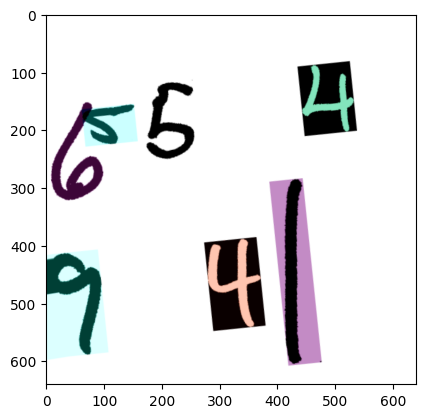

In [143]:
plt.imshow(out[0])

In [38]:
out[2]

[tensor(4.), tensor(5.), tensor(1.), tensor(1.), tensor(8.)]